# Imports

In [1]:
from sample_households import *
import sample_comorbidities
import functions

from utils.read_contact_matrix import *
from utils.compute_p_states import *

import global_parameters
import pickle, tqdm

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.neighbors import NearestNeighbors

# Parameters of the simulation

In [2]:
params = {
    'n': 1500000, # population size
    'initial_infected': 10,
    'seed': 0,
    'country': 'Italy',
    'n_ages': 101,
    'n_communities': 5,
    'sunday_lockdown_factor': 2.,
    'time_to_activation_mean': 1.621,
    'time_to_activation_std': 0.418,
    'mean_time_to_isolate_asympt': 999.,
    'mean_time_to_isolate': 4.6,
    'mean_time_to_critical': 7.5,
    'mean_time_to_severe': 7.,
    'mean_time_mild_recovery': 14.,
    't_stayhome_start': 999., # Days before beginning of the shelter
    'T': 200., # Time duration of the simulation (days)
    't_lockdown': 999., # Days before lockdown
    'lockdown_factor' : 4.,
    't_tracing_start': 3,
    'contact_tracing': float(False),
    'p_trace_household': 1.0,
    'p_trace_outside': 0.95, # Maybe put this to 0.9?
    'p_infect_given_contact': 0.029, # 0.029 for Italy, 0.020 for China and SK
    'asymptomatic_transmissibility': 0.55,
    'mortality_multiplier': 1, # 4 for Italy, 1 for others
    'p_documented_in_mild': 0.2 # NOT DOCUMENTED by Wilder & al.
}

params['mean_time_severe_recovery'] = 28. - params['mean_time_to_severe']
params['mean_time_critical_recovery'] = 35. - params['mean_time_to_severe'] - params['mean_time_to_critical'] 
params['mean_time_to_death'] = 18.5 - params['mean_time_to_severe'] - params['mean_time_to_critical']

params['p_documented_in_mild'] = global_parameters.calibrate_p_document_mild(
    p_target = 1e-11, mean_time_mild_recovery = params['mean_time_mild_recovery'])

## Simulate household and population

In [3]:
contact_matrix = 8*np.asarray(pd.read_csv('Contact_Matrices/Test.csv', sep=';', index_col='Unnamed: 0'))

In [4]:
N = [100000, 200000, 300000, 400000, 500000]

household_probs = [[0.309179, 0.196000, 0.0694283, 0.0273065, 0.00450268, 0.152655, 0.132429, 0.0200969, 0.049821, 0.033, 0.017], 
                   [0.359179, 0.146000, 0.0694283, 0.0273065, 0.00450268, 0.152655, 0.132429, 0.0200969, 0.049821, 0.033, 0.017], 
                   [0.279179, 0.196000, 0.0694283, 0.0273065, 0.00450268, 0.152655, 0.162429, 0.0200969, 0.049821, 0.033, 0.017], 
                   [0.319179, 0.206000, 0.0694283, 0.0273065, 0.00450268, 0.132655, 0.132429, 0.0200969, 0.049821, 0.033, 0.017], 
                   [0.269179, 0.146000, 0.0694283, 0.0273065, 0.00450268, 0.192655, 0.172429, 0.0200969, 0.049821, 0.033, 0.017]]

locations = [np.asarray([np.random.uniform(0, 70, 100), np.random.uniform(0, 50, 100)], dtype='int').T,
            np.asarray([np.random.uniform(0, 60, 100), np.random.uniform(0, 40, 100)], dtype='int').T,
            np.asarray([np.random.uniform(0, 70, 50), np.random.uniform(0, 15, 50)], dtype='int').T,
            np.asarray([np.random.uniform(0, 70, 100), np.random.uniform(15, 50, 100)], dtype='int').T,
            np.asarray([np.random.uniform(0, 70, 100), np.random.uniform(0, 50, 100)], dtype='int').T]

# Age distribution in CH
age_distribution = [get_age_distribution("Switzerland"), get_age_distribution("Switzerland"),
                   get_age_distribution("Switzerland"), get_age_distribution("Switzerland"),
                   get_age_distribution("Switzerland")]

mother_age_distribution = [get_mother_birth_age_distribution("Switzerland"),
                           get_mother_birth_age_distribution("Switzerland"),
                           get_mother_birth_age_distribution("Switzerland"),
                           get_mother_birth_age_distribution("Switzerland"),
                           get_mother_birth_age_distribution("Switzerland")]

households, neighbors = [], []
age, location, community = [], [], []
initial_n = 0

for i in range(len(household_probs)):
    households_, age_, location_, community_ = sample_households(N[i], initial_n, household_probs[i], locations[i], 
                                                                 age_distribution[i], mother_age_distribution[i], i,
                                                                 scale_location_var=1)
    initial_n += N[i]
    households += households_
    age.append(age_)
    location.append(location_)
    community.append(community_)
    
    neighbors.append(NearestNeighbors(n_neighbors=1, algorithm='ball_tree').fit(location_))
    
age = np.concatenate(age)
location = np.concatenate(location)
community = np.concatenate(community)

# Commuting
df = pd.read_excel('tabelle.xls', header = 2)[:21].rename(columns = {'Unnamed: 0': 'km_range', 
                'Part des déplacements [%]': 'share'})[['km_range', 'share']]
df['km'] = df.index + 1
df.drop(columns = 'km_range', inplace=True)
commuting_distance = df['share'].values/np.sum(df['share'])

# Functions

In [5]:
def do_contact_tracing(i, infected_by, p_trace_outside, Q, S, t, households, p_trace_household, Documented, 
                       time_documented, traced):
    '''
    Recursively implements tracing the tree of infectious defined by infected_by.
    NOT CURRENTLY USED in the preprint. There is no validation of this procedure
    for any particular example.
    '''
    #trace contacts within the household
    for contact in households[i]:
        if contact == -1:
            break
        if not S[t-1, contact] and not traced[contact] and np.random.rand() < p_trace_household:
            Q[t, contact] = True
            Documented[t, contact] = True
            traced[contact] = True
            time_documented[contact] = t
            do_contact_tracing(contact, infected_by, p_trace_outside, Q, S, t, households, p_trace_household, 
                               Documented, time_documented, traced)
    # Trace outside of household contacts
    for j in range(infected_by.shape[1]):
        contact = infected_by[i, j]
        if contact == -1:
            break
        if np.random.rand() < p_trace_outside:
            Q[t, contact] = True
            Documented[t, contact] = True
            time_documented[contact] = t
            traced[contact] = True
            do_contact_tracing(contact, infected_by, p_trace_outside, Q, S, t, households, p_trace_household, 
                               Documented, time_documented, traced)


In [6]:
def run_complete_simulation(params, contact_matrix, commuting_distance, households, age, location, community, 
                            neighbors, load_population=False, fraction_stay_home = 0., 
                            enable_seed = False):
    '''
    Runs simulation with given parameters (see run_simulation for details).
    If load_population is true, reads in the simulated population for the given country and size.
    Otherwise, creates and saves a new population.
    '''

    n = int(params['n'])
    n_ages = int(params['n_ages'])
    country = str(params['country'])
    if enable_seed:
        np.random.seed(params['seed'])
    
    p_mild_severe, p_severe_critical, p_critical_death = compute_p_states(params['n_ages'], 
                                                                          params['mortality_multiplier'])

    mean_time_to_isolate_factor = np.asarray([1, 1, 1, 1, 1])

    factor = params['lockdown_factor']
    lockdown_factor_community = np.asarray([factor, factor, factor, factor, factor])

    fraction_stay_home = np.zeros(params['n_ages'])
    fraction_stay_home[:] = fraction_stay_home
    
    p_infect_household = global_parameters.get_p_infect_household(
        params['n'], params['mean_time_to_isolate'], params['time_to_activation_mean'], 
        params['time_to_activation_std'], params['asymptomatic_transmissibility'])
                
    age_groups = tuple([np.where(age == i)[0] for i in range(0, n_ages)])
    community_groups = tuple([np.where(community == i)[0] for i in range(len(np.unique(community)))])

    diabetes, hypertension = sample_comorbidities.sample_joint_comorbidities(age, country)

    data = (age, households, diabetes, hypertension, age_groups)
    with open('{}_population_{}.pickle'.format(country, n), 'wb') as f:
        pickle.dump(data, f)

    print('Starting simulation')
     
    return run_model(households, age, location, community, community_groups, neighbors, diabetes, hypertension, 
                     contact_matrix, commuting_distance, p_mild_severe, p_severe_critical, p_critical_death, 
                     mean_time_to_isolate_factor, lockdown_factor_community, p_infect_household, 
                     fraction_stay_home, params)


In [7]:
def run_model(households, age, location, community, community_groups, neighbors, diabetes, hypertension, 
              contact_matrix, commuting_distance, p_mild_severe, p_severe_critical, p_critical_death, 
              mean_time_to_isolate_factor, lockdown_factor_community, p_infect_household, fraction_stay_home, params):
            
    print('run_model')
    """Run the SEIR model to completion.

    Args:
        households (int n x max_household_size matrix): Household structure (adjacency list format, each row terminated with -1s)
        age (int vector of length n): Age of each individual.
        diabetes (bool vector of length n): Diabetes state of each individual.
        hypertension (bool vector of length n): Hypertension state of each
            individual.
        contact_matrix (float matrix n_ages x n_ages): expected number of daily contacts between each pair of age groups
        p_mild_severe (float matrix n_ages x 2 x 2): probability of mild->severe transition for each age/diabetes/hypertension status
        p_severe_critical (float matrix n_ages x 2 x 2): as above but for severe->critical
        p_critical_death (float matrix n_ages x 2 x 2): as above but for critical->death
        mean_time_to_isolate_factor (float vector n_ages): scaling applied to the mean time to isolate for mild cases per age group
        lockdown_factor_age (float vector n_ages): per-age reduction in contact during lockdown. Not currently used.
        p_infect_household (float vector n): probability for each individual to infect each household member per day.
        fraction_stay_home (float vector n_ages): fraction of each age group assigned to shelter in place
        params: dict with remaining scalar parameters

    Returns:
        S (bool T x n matrix): Matrix where S[i][j] represents
            whether individual i was in the Susceptible state at time j.
        E (bool T x n matrix): same for Exposed state.
        Mild (bool T x n matrix): same for Mild state.
        Severe (bool T x n matrix): same for Severe state.
        Critical (bool T x n matrix): same for Critical state.
        R (bool T x n matrix): same for Recovered state.
        D (bool T x n matrix): same for Dead state.
        Q (bool T x n matrix): same for Quarantined state.
        num_infected_by (n vector): num_infected_by[i] is the number of individuals
            infected by individual i. -1 if they never became infectious
        time_documented (n vector): time step when each individual became a documented case, 0 if never documented
        time_to_activation (n vector): incubation time drawn for this individual, 0 if no time drawn
        time_to_death (n vector):  time-to-event for critical -> death for this individual, 0 if no time drawn
        time_to_recovery (n vector): time-to-event for infectious -> recovery for this individual, 0 if no time drawn
        time_critical (n vector): time step that this individual entered the critical state, 0 if they never entered
        time_exposed (n vector): time step that this individual became asymptomatically infected, -1 if this never happend
        num_infected_asympt (n vector): number of others infected by this individual while asymptomatic, -1 if never became infectious
        age (n vector): age of each individual
        time_infected (n vector): time step that this individual became mildly infectious, 0 if they never became infectious
        time_to_severe (n vector): time-to-event between mild and severe cases for this individual, 0 if never drawn
    """
    
    def drawCommuting(commuting_distance, location):

        distance = int(np.random.choice(np.arange(0, 21), p=commuting_distance))
        if distance >= 21:
            distance += int(np.abs(np.random.logistic(0, 20)))
        if distance > 1:
            horiz = int(np.random.uniform(0.0, 1.0)*distance)*(1+(np.random.choice([False, True])*-2))
            vert = int(np.sqrt(distance**2 - horiz**2))*(1+(np.random.choice([False, True])*-2))
        elif distance == 1:
            horiz = int(np.random.choice([False, True]))
            vert = 1-horiz
        else:
            horiz, vert = 0, 0

        return horiz + location[0], vert + location[1]

    time_to_activation_mean = params['time_to_activation_mean']
    time_to_activation_std = params['time_to_activation_std']
    mean_time_to_death = params['mean_time_to_death']
    mean_time_critical_recovery = params['mean_time_critical_recovery']
    mean_time_severe_recovery = params['mean_time_severe_recovery']
    mean_time_to_severe = params['mean_time_to_severe']
    mean_time_mild_recovery = params['mean_time_mild_recovery']
    mean_time_to_critical = params['mean_time_to_critical']
    p_documented_in_mild = params['p_documented_in_mild']
    mean_time_to_isolate_asympt = params['mean_time_to_isolate_asympt']
    asymptomatic_transmissibility = params['asymptomatic_transmissibility']
    p_infect_given_contact = params['p_infect_given_contact']
    T = int(params['T'])
    initial_infected = params['initial_infected']
    t_lockdown = int(params['t_lockdown']) 
    lockdown_factor = params['lockdown_factor']
    mean_time_to_isolate = params['mean_time_to_isolate']
    n = int(params['n'])
    n_communities = int(params['n_communities'])
    contact_tracing = bool(params['contact_tracing'])
    p_trace_outside = params['p_trace_outside']
    p_trace_household = params['p_trace_household']
    t_tracing_start = int(params['t_tracing_start'])
    t_stayinghome_start = int(params['t_stayhome_start'])
    sunday_lockdown_factor = float(params['sunday_lockdown_factor'])
    if contact_tracing:
        tracing_enabled = True
        contact_tracing = False
    else:
        tracing_enabled = False
    
    S = np.zeros((T, n), dtype=np.bool8)
    E = np.zeros((T, n), dtype=np.bool8)
    Mild = np.zeros((T, n), dtype=np.bool8)
    Documented = np.zeros((T, n), dtype=np.bool8)
    Severe = np.zeros((T, n), dtype=np.bool8)
    Critical = np.zeros((T, n), dtype=np.bool8)
    R = np.zeros((T, n), dtype=np.bool8)
    D = np.zeros((T, n), dtype=np.bool8)
    Q = np.zeros((T, n), dtype=np.bool8)
    traced = np.zeros((n), dtype=np.bool8)
    #whether each individual is assigned to shelter in place
    Home_real = np.zeros(n, dtype=np.bool8)
    Home_real[:] = False
    for i in range(n_communities):
        matches = np.where(community == i)[0]
        if matches.shape[0] > 0:
            to_stay_home = np.random.choice(matches, int(fraction_stay_home[i]*matches.shape[0]), replace=False)
            Home_real[to_stay_home] = True
    #no one shelters in place until t_stayhome_start
    dummy_Home = np.zeros(n, dtype=np.bool8)
    dummy_Home[:] = False
    Home = dummy_Home
    initial_infected = np.random.choice(n, int(initial_infected), replace=False)
    S[0] = True
    E[0] = False
    R[0] = False
    D[0] = False
    Mild[0] = False
    Documented[0]=False
    Severe[0] = False
    Critical[0] = False

    infected_by = np.zeros((n, 100), dtype=np.int32)
    infected_by[:] = -1
    
    sunday = False
    
    time_exposed = np.zeros(n)
    time_infected = np.zeros(n)
    time_severe = np.zeros(n)
    time_critical = np.zeros(n)
    time_documented=np.zeros(n)
    time_exposed[:] = -1
    #total number of infections caused by every individual, -1 if never become infectious
    num_infected_by = np.zeros(n)
    num_infected_by_outside = np.zeros(n, dtype=np.int32)
    num_infected_asympt = np.zeros(n)
    num_infected_by[:] = -1
    num_infected_by_outside[:] = -1
    num_infected_asympt[:] = -1
    time_to_severe = np.zeros(n)
    time_to_recovery = np.zeros(n)
    time_to_critical = np.zeros(n)
    time_to_death = np.zeros(n)
    time_to_isolate = np.zeros(n)
    time_to_activation = np.zeros(n)
    #initialize values for individuals infected at the starting step
    for i in range(initial_infected.shape[0]):
        E[0, initial_infected[i]] = True
        S[0, initial_infected[i]] = False
        time_exposed[initial_infected[i]] = 0
        num_infected_by[initial_infected[i]] = 0
        num_infected_by_outside[initial_infected[i]] = 0
        num_infected_asympt[initial_infected[i]] = 0
        time_to_activation[initial_infected[i]] = functions.threshold_log_normal(time_to_activation_mean, time_to_activation_std)
    
    print('Initialized finished')
    print('mean_time_to_isolate',mean_time_to_isolate)
    
    for t in tqdm.tqdm(range(1, T), desc='Days simulated'):
        if t % 7 == 0:
            contact_matrix = contact_matrix/sunday_lockdown_factor
            sunday = True
            #pass
        elif sunday:
            sunday = False
            contact_matrix = contact_matrix*sunday_lockdown_factor
            
        if t == t_lockdown:
        #   implements a reduction in contact per age group (instead of a single factor)
        #   applied to the whole population. Currently not used.
        #    for i in range(contact_matrix.shape[0]):
        #        for j in range(contact_matrix.shape[1]):
        #            contact_matrix[i,j] = contact_matrix[i,j]/(lockdown_factor_community[community[i]]*lockdown_factor_community[community[j]]))
            contact_matrix = contact_matrix/lockdown_factor
        if t == t_tracing_start and tracing_enabled:
            contact_tracing = True
        if t == t_stayinghome_start:
            Home = Home_real
        S[t] = S[t-1]
        E[t] = E[t-1]
        Mild[t] = Mild[t-1]
        Documented[t]=Documented[t-1]
        Severe[t] = Severe[t-1]
        Critical[t] = Critical[t-1]
        R[t] = R[t-1]
        D[t] = D[t-1]
        Q[t] = Q[t-1]
        for i in range(n):
            #exposed -> (mildly) infected
            if E[t-1, i]:
                if t - time_exposed[i] >= time_to_activation[i]:
                    Mild[t, i] = True
                    time_infected[i] = t
                    E[t, i] = False
                    #draw whether they will progress to severe illness
                    if np.random.rand() < p_mild_severe[age[i], diabetes[i], hypertension[i]]:
                        time_to_severe[i] = functions.threshold_exponential(mean_time_to_severe)
                        time_to_recovery[i] = np.inf
                    #draw time to recovery
                    else:
                        time_to_recovery[i] = functions.threshold_exponential(mean_time_mild_recovery)
                        time_to_severe[i] = np.inf
                    #draw time to isolation
                    time_to_isolate[i] = functions.threshold_exponential(mean_time_to_isolate*mean_time_to_isolate_factor[community[i]])
                    if time_to_isolate[i] == 0:
                        Q[t, i] = True
            #symptomatic individuals
            if (Mild[t-1, i] or Severe[t-1, i] or Critical[t-1, i]):
                #recovery
                if t - time_infected[i] >= time_to_recovery[i]:
                    R[t, i] = True
                    Mild[t, i] = Severe[t, i] = Critical[t, i] = Q[t, i] = False
                    continue
                if Mild[t-1, i] and not Documented[t-1, i]:
                    #mild cases are documented with some probability each day
                    if np.random.rand() < p_documented_in_mild:
                        Documented[t, i] = True
                        time_documented[i] = t
                        traced[i] = True
                        #do contact tracing (if enabled) whenever a case becomes documented
                        if contact_tracing:
                            Q[t, i] = True
                            do_contact_tracing(i, infected_by, p_trace_outside, Q, S, t, households, p_trace_household, Documented, time_documented, traced)
                #progression between infection states
                if Mild[t-1, i] and t - time_infected[i] >= time_to_severe[i]:
                    Mild[t, i] = False
                    Severe[t, i] = True
                    #assume that severe cases are always documented
                    if not Documented[t-1, i]:
                        Documented[t, i] = True
                        time_documented[i] = t
                        traced[i] = True
                        #assume that contact tracing is always started for severe cases
                        #(if enabled)
                        if contact_tracing:
                            Q[t, i] = True
                            do_contact_tracing(i, infected_by, p_trace_outside, Q, S, t, households, p_trace_household, Documented, time_documented, traced)
                    Q[t, i] = True
                    time_severe[i] = t
                    if np.random.rand() < p_severe_critical[age[i], diabetes[i], hypertension[i]]:
                        time_to_critical[i] = functions.threshold_exponential(mean_time_to_critical)
                        time_to_recovery[i] = np.inf
                    else:
                        time_to_recovery[i] = functions.threshold_exponential(mean_time_severe_recovery) + time_to_severe[i]
                        time_to_critical[i] = np.inf
                elif Severe[t-1, i] and t - time_severe[i] >= time_to_critical[i]:
                    Severe[t, i] = False
                    Critical[t, i] = True
                    time_critical[i] = t
                    if np.random.rand() < p_critical_death[age[i], diabetes[i], hypertension[i]]:
                        time_to_death[i] = functions.threshold_exponential(mean_time_to_death)
                        time_to_recovery[i] = np.inf
                    else:
                        time_to_recovery[i] = functions.threshold_exponential(mean_time_critical_recovery) + time_to_severe[i] + time_to_critical[i]
                        time_to_death[i] = np.inf
                #risk of mortality for critically ill patients
                elif Critical[t-1, i]:
                    if t - time_critical[i] >= time_to_death[i]:
                        Critical[t, i] = False
                        Q[t, i] = False
                        D[t, i] = True
            if E[t-1, i] or Mild[t-1, i] or Severe[t-1, i] or Critical[t-1, i]:
                #not isolated: either enter isolation or infect others
                if not Q[t-1, i]:
                    #isolation
                    if not E[t-1, i] and t - time_infected[i] == time_to_isolate[i]:
                        Q[t, i] = True
                        continue
                    if E[t-1, i] and t - time_exposed[i] == time_to_isolate[i]:
                        Q[t, i] = True
                        continue
                    #infect within family
                    for contact in households[i]:
                        infectiousness = p_infect_household[i]
                        if E[t-1, i]:
                            infectiousness *= asymptomatic_transmissibility
                        if S[t-1, contact] and np.random.rand() < infectiousness:
                                E[t, contact] = True
                                num_infected_by[contact] = 0
                                num_infected_by_outside[contact] = 0
                                num_infected_asympt[contact] = 0
                                S[t, contact] = False
                                time_to_isolate[contact] = functions.threshold_exponential(mean_time_to_isolate_asympt*mean_time_to_isolate_factor[community[contact]])
                                if time_to_isolate[contact] == 0:
                                    Q[t, contact] = True
                                time_exposed[contact] = t
                                time_to_activation[contact] = functions.threshold_log_normal(time_to_activation_mean, time_to_activation_std)
                                num_infected_by[i] += 1
                                if E[t-1, i]:
                                    num_infected_asympt[i] += 1
                    #infect across families
                    if not Home[i]:
                        infectiousness = p_infect_given_contact
                        #lower infectiousness for asymptomatic individuals
                        if E[t-1, i]:
                            infectiousness *= asymptomatic_transmissibility
                        #draw a Poisson-distributed number of contacts for each age group
                        for contact_community in range(n_communities):
                            if community_groups[contact_community].shape[0] == 0:
                                continue
                            num_contacts = np.random.poisson(contact_matrix[community[i], contact_community])
                            for j in range(num_contacts):
                                #if the contact becomes infected, handle bookkeeping
                                if np.random.rand() < infectiousness:
                                    lat, lon = drawCommuting(commuting_distance, location[i])
                                    indice = neighbors[contact_community].kneighbors([[lat, lon]], return_distance=False)
                                    #contact = np.random.choice(community_groups[contact_community])
                                    contact = community_groups[contact_community][indice]
                                    if S[t-1, contact] and not Home[contact]:
                                        E[t, contact] = True
                                        num_infected_by[contact] = 0
                                        num_infected_by_outside[contact] = 0
                                        num_infected_asympt[contact] = 0
                                        S[t, contact] = False
                                        time_to_isolate[contact] = functions.threshold_exponential(
                                            mean_time_to_isolate_asympt*mean_time_to_isolate_factor[community[contact]])
                                        if time_to_isolate[contact] == 0:
                                            Q[t, contact] = True
                                        time_exposed[contact] = t
                                        time_to_activation[contact] = functions.threshold_log_normal(
                                            time_to_activation_mean, time_to_activation_std)
                                        num_infected_by[i] += 1
                                        infected_by[i, num_infected_by_outside[i]] = contact
                                        num_infected_by_outside[i] += 1
                                        if E[t-1, i]:
                                            num_infected_asympt[i] += 1

    return S, E, Mild, Documented, Severe, Critical, R, D, Q, num_infected_by, time_documented, time_to_activation, time_to_death, time_to_recovery, time_critical, time_exposed, num_infected_asympt, age, time_infected, time_to_severe

# Results

In [8]:
(S, E, Mild, Documented, Severe, Critical, R, D, Q, num_infected_by, time_documented, time_to_activation, 
 time_to_death, time_to_recovery, time_critical, time_exposed, num_infected_asympt, age, time_infected, 
 time_to_severe) = run_complete_simulation(params, contact_matrix, commuting_distance, households, age, location, 
                                           community, neighbors, load_population=False)

Starting simulation
run_model


Days simulated:   0%|          | 0/199 [00:00<?, ?it/s]

Initialized finished
mean_time_to_isolate 4.6


/Users/remipetitpierre/Desktop/COVID/COVID19-Demography/functions.py:13: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "threshold_exponential" failed type inference due to: Invalid use of Function(np.random.exponential) with argument(s) of type(s): (array(float64, 2d, C))
Known signatures:
 * (float64,) -> float64
 * () -> float64
 * parameterized
In definition 0:
    All templates rejected with literals.
In definition 1:
    All templates rejected without literals.
This error is usually caused by passing an argument of a type that is unsupported by the named function.
[1] During: resolving callee type: Function(np.random.exponential)
[2] During: typing of call at /Users/remipetitpierre/Desktop/COVID/COVID19-Demography/functions.py (17)


File "functions.py", line 17:
def threshold_exponential(mean):
    return np.round(np.random.exponential(mean))
    ^

  @jit
/Users/remipetitpierre/miniconda3/envs/BnF/lib/python3.7/site-packages/

In [9]:
progression = pd.DataFrame({'Susceptible': np.sum(S, axis = 1),
                            'Exposed': np.sum(E, axis = 1),
                            'Mild': np.sum(Mild, axis = 1),
                            'Severe': np.sum(Severe, axis = 1),
                            'Critical': np.sum(Critical, axis = 1),
                            'Documented': np.sum(Documented, axis = 1),
                            'Healed': np.sum(R, axis = 1),
                            'Dead': np.sum(D, axis = 1),
                            'Quarantined': np.sum(Q, axis = 1)})

In [10]:
progression['Sick'] = progression['Mild'] + progression['Severe'] + progression['Critical']
progression['Infected'] = progression['Exposed'] + progression['Sick']

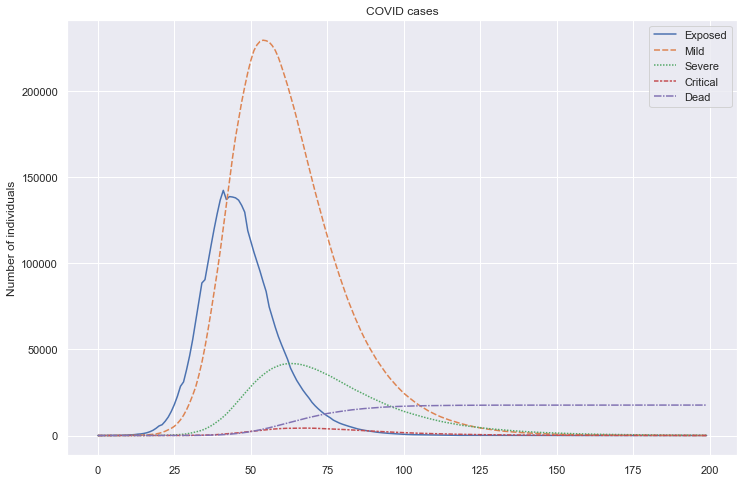

In [11]:
sns.set(rc={'figure.figsize':(12, 8)})
ax = sns.lineplot(hue="region", data=progression[['Exposed', 'Mild', 'Severe', 'Critical', 'Dead']])
ax.set_title('COVID cases')
ax.set_ylabel('Number of individuals');

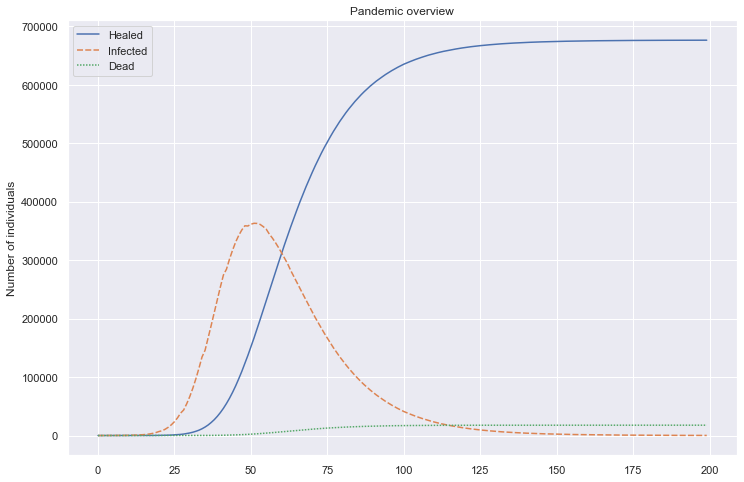

In [12]:
sns.set(rc={'figure.figsize':(12, 8)})
ax = sns.lineplot(hue="region", data=progression[['Healed', 'Infected', 'Dead']])
ax.set_title('Pandemic overview')
ax.set_ylabel('Number of individuals');

In [13]:
progression = pd.DataFrame({'Susceptible': np.sum(S, axis = 1),
                            'Exposed': np.sum(E, axis = 1),
                            'Mild': np.sum(Mild, axis = 1),
                            'Severe': np.sum(Severe, axis = 1),
                            'Critical': np.sum(Critical, axis = 1),
                            'Documented': np.sum(Documented, axis = 1),
                            'Healed': np.sum(R, axis = 1),
                            'Dead': np.sum(D, axis = 1),
                            'Quarantined': np.sum(Q, axis = 1)})

In [14]:
community_progression = []
for i in range(len(np.unique(community))):
    df = pd.DataFrame({'Susceptible': np.sum(S[:,community == i], axis = 1),
                        'Exposed': np.sum(E[:,community == i], axis = 1),
                        'Mild': np.sum(Mild[:,community == i], axis = 1),
                        'Severe': np.sum(Severe[:,community == i], axis = 1),
                        'Critical': np.sum(Critical[:,community == i], axis = 1),
                        'Documented': np.sum(Documented[:,community == i], axis = 1),
                        'Healed': np.sum(R[:,community == i], axis = 1),
                        'Dead': np.sum(D[:,community == i], axis = 1),
                        'Quarantined': np.sum(Q[:,community == i], axis = 1),
                        'Community': i})
    community_progression.append(df)
    
community_progression = pd.concat(community_progression, axis=0)
community_progression['Day'] = community_progression.index
community_progression.reset_index(drop=True, inplace=True)

In [15]:
community_progression['Sick'] = community_progression['Mild'] + community_progression['Severe'] + community_progression['Critical']
community_progression['Infected'] = community_progression['Exposed'] + community_progression['Sick']

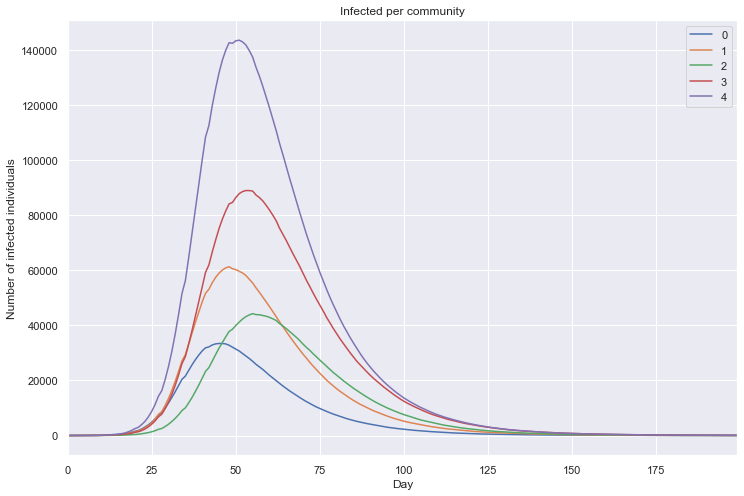

In [16]:
fig, ax = plt.subplots()
ax.set_title('Infected per community')
ax.set_ylabel('Number of infected individuals')

for label, com in community_progression.groupby('Community'):
    com.plot(x = 'Day', y = 'Infected',ax = ax, label = label)